In [1]:
import pandas as pd
from functions import *
from visualizacion import *
from train import *
from inferencia import predict_from_model
from config import *
from backtesting import *

In [2]:
moneda = 'BTCUSDT'

# Carga de BTC
df_btc = read_data(moneda)

In [3]:
df_btc, col_rsi = add_rsi(df_btc)
df_btc, col_ema = add_ema(df_btc, period=12, price_col='close', verbose=True)
df_btc, col_ema = add_ema(df_btc, period=6, price_col='close', verbose=True)
df_btc, col_ema_cross = add_ema_cross(df_btc, fast=12, slow=26, price_col='close', verbose=True)

✅ Añadido rsi_14: mide momentum (fuerza relativa) en los últimos 14 cierres. Valores >70 = sobrecompra, <30 = sobreventa.
✅ Añadido ema_12: media móvil exponencial sobre close en 12 velas. Señala tendencias con mayor sensibilidad que una SMA.
✅ Añadido ema_6: media móvil exponencial sobre close en 6 velas. Señala tendencias con mayor sensibilidad que una SMA.
✅ Añadido ema_cross_signal_12_26: señales de cruce entre EMA12 y EMA26. 1 = cruce alcista, -1 = cruce bajista, 0 = sin cruce.


In [4]:
# Filtramos solo por las ultimas fechas
df_btc, df_test = filtrar_fecha(df_btc, total_anios = 5, eliminar_anios_final = .5)

# Obtenemos las columnas de resultados para cada caso
df_btc, col_outcome, col_gain_bool = add_trade_outcome(df_btc, horizon=24, take_profit = TAKE_PROFIT, stop_loss= STOP_LOSS)

# Obtenemos la dependencia con la salida
ranking = calcular_importancia_features(df_btc)

✅ Añadida columna result_trade_outcome_24N_3TP_1SL: resultado del trade en las próximas 24 velas.
✅ Añadida columna result_gain_24N_3TP_1SL_bool: indica si se alcanzó el take profit.
   'take_profit' si el precio subió al menos 3% antes que la caída de 1%.
   'stop_loss' si la caída ocurrió antes que la subida objetivo.
   'ninguno' si ninguna condición se cumplió en el horizonte.
✅ Importancia de features respecto a la salida binaria 'result_gain_24N_3TP_1SL_bool':

   ema_26                         ➜ 0.0207
   ema_12                         ➜ 0.0183
   ema_6                          ➜ 0.0163
   low                            ➜ 0.0160
   high                           ➜ 0.0157
   close                          ➜ 0.0153
   open                           ➜ 0.0153
   volume                         ➜ 0.0078
   rsi_14                         ➜ 0.0028
   ema_cross_signal_12_26         ➜ 0.0002


In [5]:
# Balanceamos datos
df_btc, _ = balanced_methods(df_btc)

# Creamos el modelo
modelo, feature_cols, target_col = execute_random_forest(df_btc, )

✅ RandomForest entrenado con 100 árboles.
Features usadas: ['open', 'high', 'low', 'close', 'volume', 'rsi_14', 'ema_12', 'ema_6', 'ema_26', 'ema_cross_signal_12_26']
Target: result_gain_24N_3TP_1SL_bool
Tamaño train: 14048, test: 3512
Resultados en test:
  Accuracy : 0.7694
  Precision: 0.7495
  Recall   : 0.8092
  F1-score : 0.7782


----- Resumen Backtesting -----
Capital inicial: 100.00
Capital final: 112.90
Diferencia: 12.90
Diferencia porcentual: 12.90%
Operaciones cerradas por tipo:
  SL: 139
  TP: 59
Total operaciones cerradas: 198
--------------------------------
Mostrando gráfico de columnas: ['disponible', 'open']
Rango fechas: 2025-01-06 00:50:00 - 2025-07-07 00:50:00
Cantidad de datos: 26094


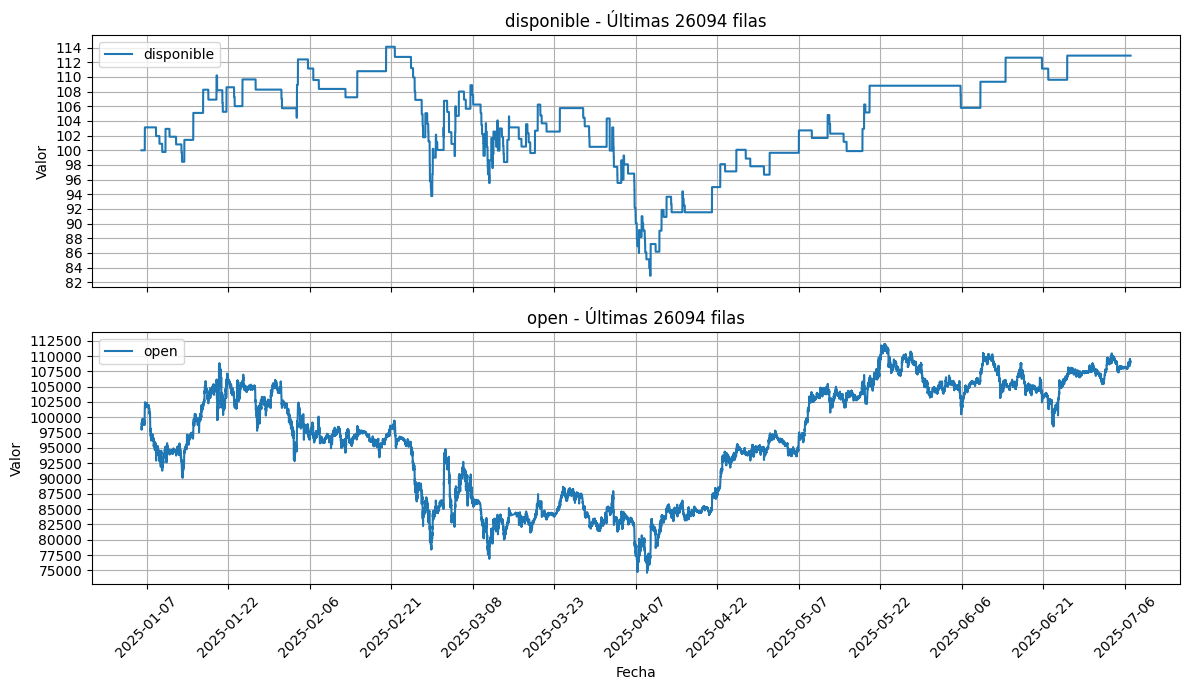

In [6]:
# Predecimos con el modelo ya entrenado para una fila o varias
pred = predict_from_model(df_test, modelo, feature_cols, threshold=THRESHOLD, return_probs=True)

pred.to_csv('predicciones.csv', index=False)

back = backtesting(pred)

back_testing_resume(back)
back_testing_graph(back)

back.to_csv('back.csv')